# ConvNet for image classification (CIFAR-10)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tqdm import tqdm

%matplotlib inline

## Load CIFAR-10

In [2]:
def load_cifar10(num_training=49000, num_validation=1000, num_test=10000, shuffle=False):
    # Load the raw CIFAR-10 dataset and use appropriate data types and shapes
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Shuffle the data
    if shuffle:
        indices_train = np.arange(len(y_train))
        np.random.shuffle(indices_train)
        X_train = X_train[indices_train]
        y_train = y_train[indices_train]
        
        indices_test = np.arange(len(y_test))
        np.random.shuffle(indices_test)
        X_test = X_test[indices_test]
        y_test = y_test[indices_test]
    
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean pixel and divide by std
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel
    
    stats = {}
    stats['mean_pixel'] = mean_pixel
    stats['std_pixel'] = std_pixel
    
    # Classes
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    return X_train, y_train, X_val, y_val, X_test, y_test, classes, stats


X_train, y_train, X_val, y_val, X_test, y_test, classes, stats = load_cifar10(shuffle=True)
print('Classes: ', classes)
print('Train data shape: ', X_train.shape, '[', X_train.min(), X_train.max(), ']', X_train.dtype)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Classes:  ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train data shape:  (49000, 32, 32, 3) [ -1.9893823 2.1264446 ] float32
Train labels shape:  (49000,) int32
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Look at some images

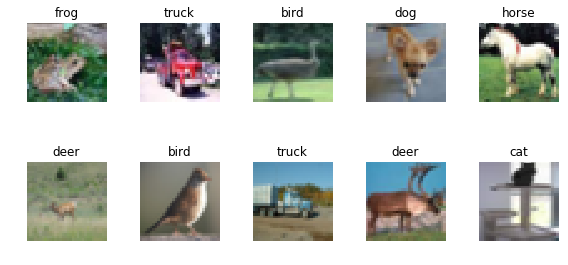

In [3]:
plt.figure(figsize=(8, 4))
batch = (X_train[0:10] * stats['std_pixel'] + stats['mean_pixel']) / 255.0

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(batch[i].astype('float32'))
    plt.axis('off')
    plt.title(classes[y_train[i]])

plt.tight_layout()

## ConvNet

In [4]:
def conv_net(x):
    with tf.variable_scope('conv1'):
        w1 = tf.get_variable('w1', shape=[5, 5, 3, 16], initializer=tf.keras.initializers.he_normal())
        b1 = tf.get_variable('b1', shape=[16], initializer=tf.initializers.zeros)
    
    with tf.variable_scope('conv2'):
        w2 = tf.get_variable('w2', shape=[5, 5, 16, 16], initializer=tf.keras.initializers.he_normal())
        b2 = tf.get_variable('b2', shape=[16], initializer=tf.initializers.zeros)
        
    with tf.variable_scope('fc3'):
        w3 = tf.get_variable('w3', shape=[400, 200], initializer=tf.keras.initializers.he_normal())
        b3 = tf.get_variable('b3', shape=[200], initializer=tf.initializers.zeros)
    
    with tf.variable_scope('fc4'):
        w4 = tf.get_variable('w4', shape=[200, 10], initializer=tf.keras.initializers.he_normal())
        b4 = tf.get_variable('b4', shape=[10], initializer=tf.initializers.zeros)
    
    # l1 (conv)
    conv1 = tf.nn.conv2d(x, w1, strides=[1, 1, 1, 1], padding='VALID', name='conv1') + b1
    relu1 = tf.nn.relu(conv1, name='relu1')
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                               padding='VALID', name='max_pool1')
    
    # l2 (conv)
    conv2 = tf.nn.conv2d(max_pool1, w2, strides=[1, 1, 1, 1], padding='VALID', name='conv2') + b2
    relu2 = tf.nn.relu(conv2, name='relu2')
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                               padding='VALID', name='max_pool1')
    max_pool2_reshaped = tf.reshape(max_pool2, [-1, 400])
    
    # l3 (fc)
    fc3 = tf.matmul(max_pool2_reshaped, w3) + b3
    relu3 = tf.nn.relu(fc3, name='relu3')
    
    # l4 (fc)
    logits = tf.matmul(relu3, w4) + b4
    
    return logits

In [5]:
def accuracy(y_pred, y):
    return np.sum(y_pred == y) / np.float32(y.size)

# reset default graph
tf.reset_default_graph()

# placeholders
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.int32)

# logits
logits = conv_net(x)

# prediction
prediction = tf.argmax(logits, axis=1)

# loss
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(losses)

# optimizer
optimize = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

# prepare for training
EPOCHS = 70
BATCH_SIZE = 128
N = len(y_train)

start_indices = list(range(0, N, BATCH_SIZE))
end_indices = list(range(BATCH_SIZE, N, BATCH_SIZE))
if end_indices[-1] != N:
    end_indices.append(N)

train_acc = np.zeros(EPOCHS)
train_loss = np.zeros(EPOCHS)
val_acc = np.zeros(EPOCHS)
val_loss = np.zeros(EPOCHS)
weights = {}

# let's train the conv_net
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for epoch in tqdm(range(EPOCHS)):
        # optimization
        for start_idx, end_idx in zip(start_indices, end_indices):
            sess.run(optimize,
                     feed_dict={
                         x: X_train[start_idx:end_idx],
                         y: y_train[start_idx:end_idx]
                     })
        
        # train acc and loss
        train1_pred_epoch, train1_loss_epoch = sess.run([prediction, loss],
                                                        feed_dict={
                                                            x: X_train[:24500],
                                                            y: y_train[:24500]
                                                        })
        train2_pred_epoch, train2_loss_epoch = sess.run([prediction, loss],
                                                        feed_dict={
                                                            x: X_train[24500:],
                                                            y: y_train[24500:]
                                                        })
        train_acc[epoch] = accuracy(y_pred=np.concatenate((train1_pred_epoch, train2_pred_epoch)),
                                    y=y_train)
        train_loss[epoch] = np.mean([train1_loss_epoch, train2_loss_epoch])
        
        # val acc and loss
        val_pred_epoch, val_loss_epoch = sess.run([prediction, loss],
                                                  feed_dict={
                                                      x: X_val,
                                                      y: y_val
                                                  })
        val_acc[epoch] = accuracy(y_pred=val_pred_epoch, y=y_val)
        val_loss[epoch] = val_loss_epoch
        
        weights[epoch] = [tf.get_default_graph().get_tensor_by_name('conv1/w1:0').eval(),
                          tf.get_default_graph().get_tensor_by_name('conv2/w2:0').eval()]

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


100%|██████████| 70/70 [04:20<00:00,  3.74s/it]


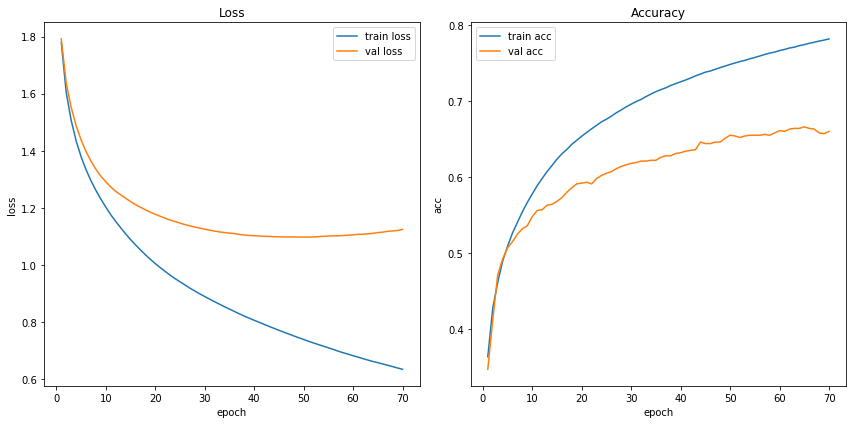

In [6]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(EPOCHS) + 1, train_loss, label='train loss')
plt.plot(np.arange(EPOCHS) + 1, val_loss, label='val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')


plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(EPOCHS) + 1, train_acc, label='train acc')
plt.plot(np.arange(EPOCHS) + 1, val_acc, label='val acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.tight_layout()

epoch: 1


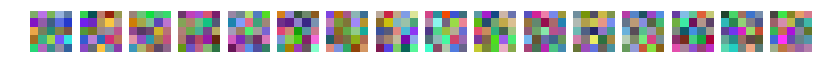

epoch: 11


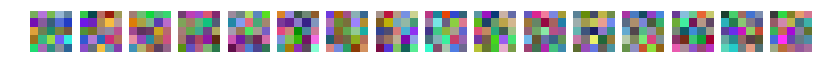

epoch: 21


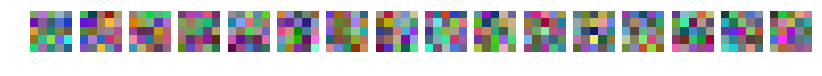

epoch: 30


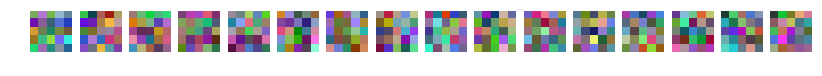

In [7]:
def plot_w(w):
    w_min = w.min()
    w_max = w.max()
    #print(w.min(), w.max())
    w = (w - w_min) / (w_max - w_min)
    
    plt.figure(figsize=(14, 8))
    for i in range(16):
        plt.subplot(1, 16, i + 1)
        plt.imshow(w[:, :, :3, i].astype(np.float32))
        plt.axis('off')
    plt.show()   

for epoch in [0, 10, 20, 29]:
    print(f'epoch: {epoch+1}')
    plot_w(weights[epoch][0])
    #plot_w(weights[epoch][1])